In [1]:
# import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from neuralprophet import NeuralProphet, uncertainty_evaluate, set_log_level, set_random_seed
import logging
import warnings
logging.getLogger('prophet').setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

d:\conda_envs\prophet\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


,ds,y
0,2017-05-01 00:00:00,27.8
1,2017-05-01 00:05:00,27.0
2,2017-05-01 00:10:00,26.8
3,2017-05-01 00:15:00,26.5
4,2017-05-01 00:20:00,25.6


,ds,y
18716,2017-07-04 23:40:00,42.8
18717,2017-07-04 23:45:00,43.0
18718,2017-07-04 23:50:00,42.1
18719,2017-07-04 23:55:00,42.1
18720,2017-07-05 00:00:00,41.4


INFO - (NP.df_utils._infer_frequency) - Major frequency 5min corresponds to 99.995% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 5min corresponds to 99.994% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 5min corresponds to 99.994% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_u

(14959, 2) (997, 2) (1595, 2) (1170, 2)


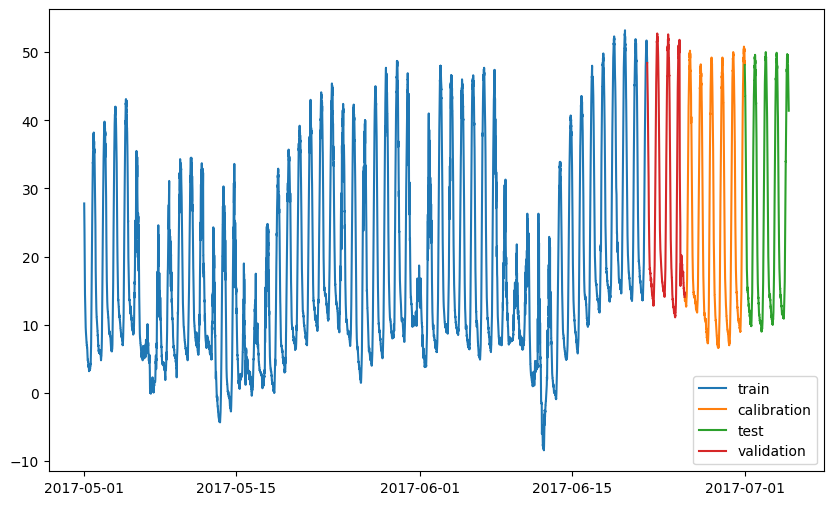

In [2]:
# data preparation
df = pd.read_csv('dataset/yosemite_temps.csv')
display(df.head())
display(df.tail())

m = NeuralProphet() # create an instance of NeuralProphet
df['ds'] = pd.to_datetime(df['ds']) # convert the 'ds' column to datetime
df_train, df_test = m.split_df(df, freq="5min", valid_p=1.0 / 16) # split the data into training and testing sets with a validation set of 1/16
df_train, df_cal = m.split_df(df_train, freq="5min", valid_p=1.0 / 11) # split the training set into training and calibration sets with a validation set of 1/11
df_train, df_val = m.split_df(df_train, freq="5min", valid_p=1.0 / 16) # split the training set into training and validation sets with a validation set of 1/6
print(df_train.shape, df_val.shape, df_cal.shape, df_test.shape)

# plot the data
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(df_train.ds, df_train.y, label="train")
ax.plot(df_cal.ds, df_cal.y, label="calibration")
ax.plot(df_test.ds, df_test.y, label="test")
ax.plot(df_val.ds, df_val.y, label="validation")
ax.legend()
plt.show()

In [3]:
# base model

# parameters
set_random_seed(0)
confidence_lv = 0.9
quantile_list = [round(((1 - confidence_lv) / 2), 2), round((confidence_lv + (1 - confidence_lv) / 2), 2)] # 0.05 and 0.95 quantiles
n_lags = 6 * 12 # predict the value in next 5 minutes using the last 6 hours of data

# simple quantile regression model
cp_model1 = NeuralProphet(quantiles=quantile_list)
cp_model1.set_plotting_backend("plotly-static")

# autoregression model with multiple layers
cp_model2 = NeuralProphet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=n_lags,
    n_forecasts= 3,
    ar_layers=[32, 32, 32, 32],
    learning_rate=0.003,
    quantiles=quantile_list,
)
cp_model2.set_plotting_backend("plotly-static")

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency 5min corresponds to 99.993% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 128
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (117) is too small than the required number                     for the learning rate finder (254). The results might not be optimal.
Finding best initial lr: 100%|██████████| 254/254 [00:02<00:00, 121.97it/s]


Epoch 10: 100%|██████████| 10/10 [00:00<00:00, 10.56it/s, loss=0.0229, v_num=45, MAE_val=4.290, RMSE_val=5.550, Loss_val=0.0334, RegLoss_val=0.000, MAE=4.300, RMSE=6.110, Loss=0.0228, RegLoss=0.000]  
Loss        0.022824
Loss_val    0.033442
Name: 9, dtype: float64


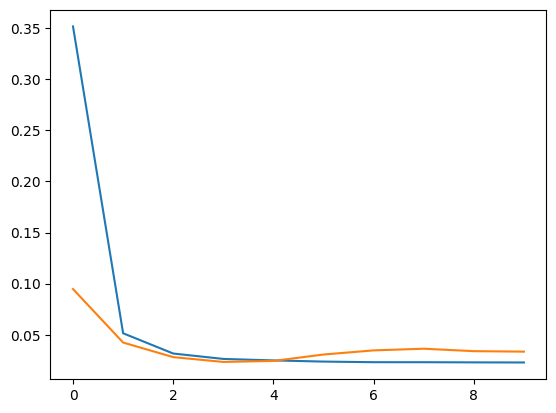

In [4]:
# train the simple base model
set_random_seed(42)
metrics1 = cp_model1.fit(df_train, validation_df=df_val, freq="5min", progress="plot", epochs=10)
print(metrics1.iloc[-1][["Loss", "Loss_val"]]) # print the loss values


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency 5min corresponds to 99.993% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 128


Epoch 10: 100%|██████████| 10/10 [00:01<00:00,  5.62it/s, loss=0.004, v_num=46, MAE_val=1.340, RMSE_val=2.030, Loss_val=0.00587, RegLoss_val=0.000, MAE=1.200, RMSE=1.750, Loss=0.00411, RegLoss=0.000]  
Loss        0.004110
Loss_val    0.005868
Name: 9, dtype: float64


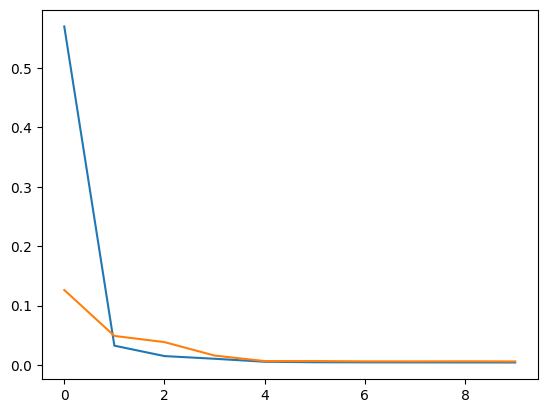

In [5]:
# train the autoregression model
metrics2 = cp_model2.fit(df_train, validation_df=df_val, freq="5min", progress="plot", epochs=10)
print(metrics2.iloc[-1][["Loss", "Loss_val"]]) # print the loss values

In [6]:
# Conformalized Quantile Regression (CQR) model

# parameters
method = "cqr" # conformalized quantile regression
alpha = 1 - confidence_lv # significance level
# simple quantile regression model
cqr_forecast1 = cp_model1.conformal_predict(df_test,calibration_df=df_cal, method=method, alpha=alpha, plotting_backend="plotly-static")


# autoregression model with multiple layers
cqr_forecast2 = cp_model2.conformal_predict(df_test,calibration_df=df_cal, method=method, alpha=alpha, plotting_backend="plotly-static")

INFO - (NP.df_utils._infer_frequency) - Major frequency 5min corresponds to 99.937% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO - (NP.df_utils._infer_frequency) - Major frequency 5min corresponds to 99.937% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 89.32it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 5min corresponds to 99.915% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO - (NP.df_utils._infer_frequency) - Major frequency 5min corresponds to 99.915% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 98.30it/s] 

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


INFO - (NP.df_utils._infer_frequency) - Major frequency 5min corresponds to 99.937% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO - (NP.df_utils._infer_frequency) - Major frequency 5min corresponds to 99.937% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 36.47it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 5min corresponds to 99.915% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO - (NP.df_utils._infer_frequency) - Major frequency 5min corresponds to 99.915% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 66.69it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.


Simple Quantile Regression Model            yhat1                 
  interval_width miscoverage_rate
0      40.311195         0.278632
 
Autoregression Model            yhat1                           yhat2                   \
  interval_width miscoverage_rate interval_width miscoverage_rate   
0      12.671513          0.07938            NaN         0.090328   

           yhat3                   
  interval_width miscoverage_rate  
0            NaN         0.073905  


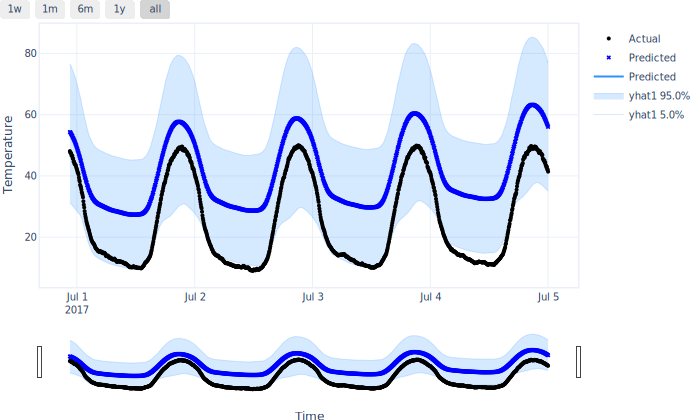

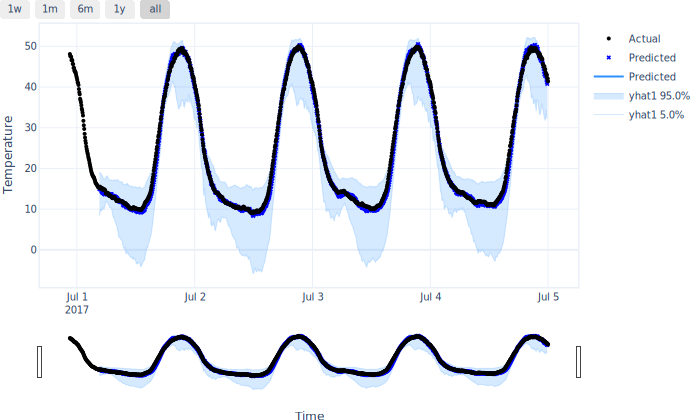

In [7]:
# evaluation
cqr_metrics1 = uncertainty_evaluate(cqr_forecast1) # evaluate the simple quantile regression model
cqr_metrics2 = uncertainty_evaluate(cqr_forecast2) # evaluate the autoregression model
print("Simple Quantile Regression Model", cqr_metrics1)
print(" ")
print("Autoregression Model", cqr_metrics2)

# Plot the forecast with the confidence interval
cutoff = 7 * 24 * 12 # 7 days
fig1 = cp_model1.highlight_nth_step_ahead_of_each_forecast(1).plot(
    cqr_forecast1[-cutoff:], plotting_backend="plotly-static", figsize=(10, 6), xlabel="Time", ylabel="Temperature"
)
fig2 = cp_model2.highlight_nth_step_ahead_of_each_forecast(1).plot(
    cqr_forecast2[-cutoff:], plotting_backend="plotly-static", figsize=(10, 6), xlabel="Time", ylabel="Temperature"
)